# COVID-19 Case Data (San Bernardino)

Data provided by California Health and Human Services Open Data Portal: [California COVID-19 Hospital Data and Case Statistics](https://data.chhs.ca.gov/dataset/california-covid-19-hospital-data-and-case-statistics).

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/covid19data.csv")

# Make index the date column.
df.index = pd.DatetimeIndex(df['Most Recent Date'])
df.pop('Most Recent Date')

df.head(2)

,County Name,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients
Most Recent Date,,,,,,,
2020-04-01,Los Angeles,3502.0,66.0,739.0,1332.0,335.0,220.0
2020-04-01,San Bernardino,245.0,5.0,95.0,196.0,39.0,52.0


In [2]:
df_sb = df[df['County Name'] == 'San Bernardino']

#Check data types of columns.
df_sb.dtypes

County Name                              object
Most Recent Date                         object
Total Count Confirmed                   float64
Total Count Deaths                      float64
COVID-19 Positive Patients              float64
Suspected COVID-19 Positive Patients    float64
ICU COVID-19 Positive Patients          float64
ICU COVID-19 Suspected Patients         float64
dtype: object

In [3]:
#Convert date to datetime object.

df_sb['Most Recent Date'] = pd.to_datetime(df_sb['Most Recent Date'])
df_sb.sort_values(by=['Most Recent Date'], inplace=True, ascending=False)

C:\Users\shoyr\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\shoyr\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


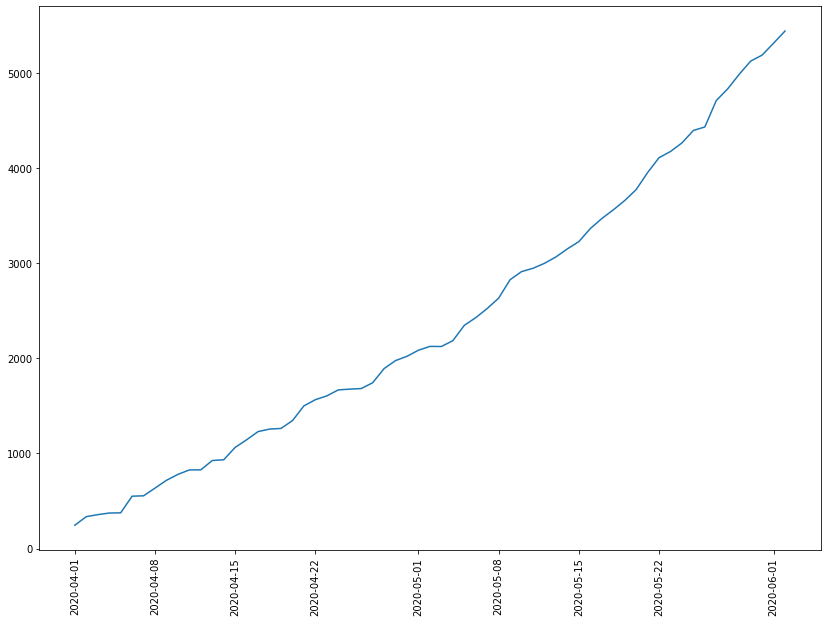

In [4]:
plt.figure(figsize=(14,10))
plt.plot(df_sb['Most Recent Date'], df_sb['Total Count Confirmed'])
plt.xticks(rotation='vertical')
plt.show()

In [5]:
# Generate column with new cases.

lag = df_sb['Total Count Confirmed'].shift(-1)
df_sb['New Confirmed Cases'] = df_sb['Total Count Confirmed'] - lag
df_sb.head(5)

C:\Users\shoyr\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,New Confirmed Cases
3692,San Bernardino,2020-06-02,5438.0,208.0,156.0,70.0,63.0,13.0,128.0
3633,San Bernardino,2020-06-01,5310.0,204.0,148.0,69.0,62.0,17.0,125.0
3574,San Bernardino,2020-05-31,5185.0,204.0,136.0,73.0,53.0,10.0,63.0
3515,San Bernardino,2020-05-30,5122.0,204.0,130.0,95.0,52.0,12.0,139.0
3456,San Bernardino,2020-05-29,4983.0,199.0,134.0,95.0,50.0,13.0,152.0


C:\Users\shoyr\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


NameError: name 'date' is not defined

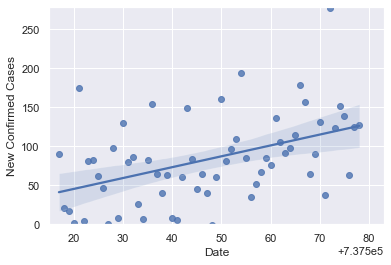

In [20]:
df_sb['date_ordinal'] = pd.to_datetime(df_sb['Most Recent Date']).apply(lambda date: date.toordinal())

ax = sns.regplot(data=df_sb, x='date_ordinal', y='New Confirmed Cases')

ax.set_xlim(df_sb['date_ordinal'].min() - 1, df_sb['date_ordinal'].max() + 5)
ax.set_ylim(0, df_sb['New Confirmed Cases'].max() + 1)

# Replace ordinal X-axis labels with regular dates.
ax.set_xlabel('Date')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)